In [1]:
%matplotlib inline

# main libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# work with sql
import psycopg2 
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL

In [2]:
# set folder for files
folder = 'bench_files'
# set plt style
plt.style.use('ggplot')

# Creating dataset

In [3]:
class SynthDF(pd.DataFrame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @property
    def _constructor(self):
        return SynthDF
    
    @classmethod
    def create_data(cls, size):
        """
        Create a synthetic DataFrame with random data.

        Parameters
        ----------
        size : int
            Number of rows in the DataFrame.
        """
        df = cls()
        
        # dates
        dates = pd.date_range('2024-01-01', '2024-12-31')
        df['date'] = np.random.choice(dates, size)
        # int data
        df['tournament_id'] = np.arange(size)
        df['team_id'] = np.random.randint(1, 1000, size)
        df['members'] = np.random.randint(1, 10, size)
        # categorical data
        df['location'] = np.random.choice(['Asia', 'Europe', 'Africa', 'America', 'Oceania'], size)
        df['importance'] = np.random.choice(['local', 'minor', 'major'], size)

        # float data
        df['avg_age'] = np.random.randint(100, 500, size) / 10
        df['prize'] = np.random.randint(10000, 10000000, size) / 100
        df['prob'] = np.random.uniform(0, 1, size)
        # bool data
        df['win'] = np.random.choice([True, False], size)
        
        return df

    def dtypes_setter(self):
        """
        Set data types for columns in a synthetic DataFrame.

        - Integers: 'tournament_id' ('int32'), 'team_id' ('int16'), 'members' ('int8').
        - Categorical: 'location', 'importance'.
        - Floats: 'avg_age' ('float16'), 'prize' ('float32'), 'prob' ('float32').
        """

        # int data
        self['tournament_id'] = self['tournament_id'].astype('int32')
        self['team_id'] = self['team_id'].astype('int16')
        self['members'] = self['members'].astype('int8')

        # categorical data
        self['location'] = self['location'].astype('category')
        self['importance'] = self['importance'].astype('category')

        # float data
        self['avg_age'] = self['avg_age'] .astype('float32')
        self['prize'] = self['prize'].astype('float32')
        self['prob'] = self['prob'].astype('float32')

    def benchmark(self, f_name, write_method, read_method, kwargs_write={}, kwargs_read={}):
        """
        Benchmark the performance and space requirements of writing and reading a DataFrame.

        Parameters
        ----------
        f_name : str
            The name of the file to be used for benchmarking.
        write_method : callable
            The method used to write the DataFrame to a file.
        read_method : callable
            The method used to read the DataFrame from a file.
        kwargs_write : dict, optional
            Additional keyword arguments for the write method.
        kwargs_read : dict, optional
            Additional keyword arguments for the read method.

        Returns
        -------
        dict
            A dictionary containing benchmark results.
            - 'format': The file format extension.
            - 'df_size': The size identifier of the DataFrame.
            - 'write': Timing information for the write operation.
            - 'read': Timing information for the read operation.
            - 'size': The size of the file on disk.
            - 'metadata': Whether metadata (data types) is preserved in the read operation.
        """
        # set path to file 
        file = os.path.join(folder, f_name)

        # bench write time
        write = %timeit -o write_method(self, file, **kwargs_write)

        # bench read time
        read = %timeit -o read_method(file, **kwargs_read)

        # bench size of file
        space = os.path.getsize(file)
        print(f'{space} bytes (required space)')

        # metadata
        new_df = read_method(file, **kwargs_read)
        ziped = zip(new_df.dtypes, self.dtypes) 
        saved_metadata = [type1.base == type2.base for type1, type2 in ziped]
        print('metadata is saved' if all(saved_metadata) else 'metadata is NOT saved')

        result = {
            'format': f_name.split('.')[-1],
            'df_size': f_name.split('_')[0],
            'write': write.average,
            'read': read.average,
            'size': space,
            'metadata': all(saved_metadata)
        }

        return result

In [12]:
# data synthesis
df_small = SynthDF.create_data(10000)
df_medium = SynthDF.create_data(100000)
df_large = SynthDF.create_data(1000000)

# change dtypes
df_small.dtypes_setter()
df_medium.dtypes_setter()
df_large.dtypes_setter()

In [13]:
# init df for result
result = pd.DataFrame(columns=['format','df_size','write', 'read', 'size', 'metadata'])

# CSV

In [14]:
temp = df_small.benchmark(
    f_name='s_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

66.4 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.7 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
657107 bytes (required space)
metadata is NOT saved


In [15]:
temp = df_medium.benchmark(
    f_name='m_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

606 ms ± 20.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
144 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
6670239 bytes (required space)
metadata is NOT saved


In [16]:
temp = df_large.benchmark(
    f_name='l_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

6.12 s ± 93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.32 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
67699733 bytes (required space)
metadata is NOT saved


# JSON

In [17]:
temp = df_small.benchmark(
    f_name='s_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

16.3 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
64.8 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1552830 bytes (required space)
metadata is NOT saved


In [18]:
temp = df_medium.benchmark(
    f_name='m_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

184 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
849 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
16629488 bytes (required space)
metadata is NOT saved


In [19]:
temp = df_large.benchmark(
    f_name='l_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

3.38 s ± 65.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.6 s ± 653 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
177273602 bytes (required space)
metadata is NOT saved


# SQL?

# Pickle

In [20]:
temp = df_small.benchmark(
    f_name='s_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

859 µs ± 8.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
611 µs ± 4.37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
301977 bytes (required space)
metadata is saved


In [21]:
temp = df_medium.benchmark(
    f_name='m_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

2.53 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.56 ms ± 41.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
3002062 bytes (required space)
metadata is saved


In [22]:
temp = df_large.benchmark(
    f_name='l_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

23 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.9 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
30002062 bytes (required space)
metadata is saved


# Feather
`
!pip istall pyarrow
`

In [23]:
temp = df_small.benchmark(
    f_name='s_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

3.88 ms ± 51.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.77 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
229162 bytes (required space)
metadata is saved


In [24]:
temp = df_medium.benchmark(
    f_name='m_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

8.38 ms ± 86.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.81 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2189250 bytes (required space)
metadata is saved


In [25]:
temp = df_large.benchmark(
    f_name='l_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

45.2 ms ± 621 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.4 ms ± 732 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21826370 bytes (required space)
metadata is saved


# Parquet
`
!pip istall fastparquet
`

In [26]:
temp = df_small.benchmark(
    f_name='s_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

9.69 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.22 ms ± 73.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
235505 bytes (required space)
metadata is saved


In [27]:
temp = df_medium.benchmark(
    f_name='m_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

20.7 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.55 ms ± 82.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2311325 bytes (required space)
metadata is saved


In [28]:
temp = df_large.benchmark(
    f_name='l_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

154 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
72.2 ms ± 737 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23061456 bytes (required space)
metadata is saved


# Show results

In [140]:
result['size'] /= 1_000_000 # convert to MB
result

,format,df_size,write,read,size,metadata
0,csv,s,0.066415,0.015717,0.657107,False
1,csv,m,0.606343,0.144178,6.670239,False
2,csv,l,6.121764,1.315749,67.699733,False
3,json,s,0.016263,0.064841,1.55283,False
4,json,m,0.183965,0.84906,16.629488,False
5,json,l,3.376944,11.60459,177.273602,False
6,pickle,s,0.000859,0.000611,0.301977,True
7,pickle,m,0.002531,0.001555,3.002062,True
8,pickle,l,0.023044,0.019868,30.002062,True
9,feather,s,0.003882,0.002766,0.229162,True


# Group data

In [143]:
# group DF by 'format' and 'df_size'
grouped = result.groupby(['format', 'df_size']).mean().unstack()
grouped

write                          read                      \
df_size         l         m         s         l         m         s   
format                                                                
csv      6.121764  0.606343  0.066415  1.315749  0.144178  0.015717   
feather  0.045233  0.008382  0.003882  0.043445  0.006815  0.002766   
json     3.376944  0.183965  0.016263  11.60459   0.84906  0.064841   
parquet  0.154439  0.020674  0.009689  0.072157  0.008551  0.004218   
pickle   0.023044  0.002531  0.000859  0.019868  0.001555  0.000611   

               size                      metadata            
df_size           l          m         s        l    m    s  
format                                                       
csv       67.699733   6.670239  0.657107      0.0  0.0  0.0  
feather    21.82637    2.18925  0.229162      1.0  1.0  1.0  
json     177.273602  16.629488   1.55283      0.0  0.0  0.0  
parquet   23.061456   2.311325  0.235505      1.0  1.0  1.0  
pickle    30.002062   3.002062  0.301977      1.0  1.0  1.0

In [144]:
binary = grouped.query('format not in ["csv", "json"]')
binary

write                          read                      \
df_size         l         m         s         l         m         s   
format                                                                
feather  0.045233  0.008382  0.003882  0.043445  0.006815  0.002766   
parquet  0.154439  0.020674  0.009689  0.072157  0.008551  0.004218   
pickle   0.023044  0.002531  0.000859  0.019868  0.001555  0.000611   

              size                     metadata            
df_size          l         m         s        l    m    s  
format                                                     
feather   21.82637   2.18925  0.229162      1.0  1.0  1.0  
parquet  23.061456  2.311325  0.235505      1.0  1.0  1.0  
pickle   30.002062  3.002062  0.301977      1.0  1.0  1.0

# Draw graphs

In [167]:
def plot_data(df, title='', y_label=''):
    ax = df.plot(kind='bar', figsize=(12, 6), width=0.8, logy=True)
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 4)), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 30), 
                    textcoords='offset points',
                    rotation=90
                   )

    plt.title(title)
    plt.xlabel('File format')
    plt.xticks(rotation=0)
    plt.ylabel(y_label)
    plt.ylim(top=df.max().max()*10)

## read

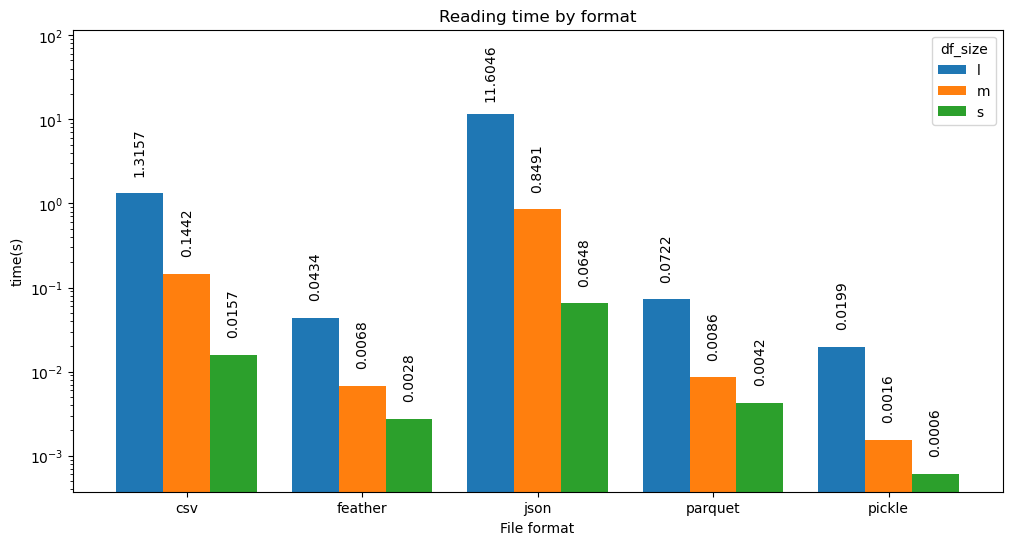

In [168]:
plot_data(grouped['read'], 'Reading time by format', 'time(s)')

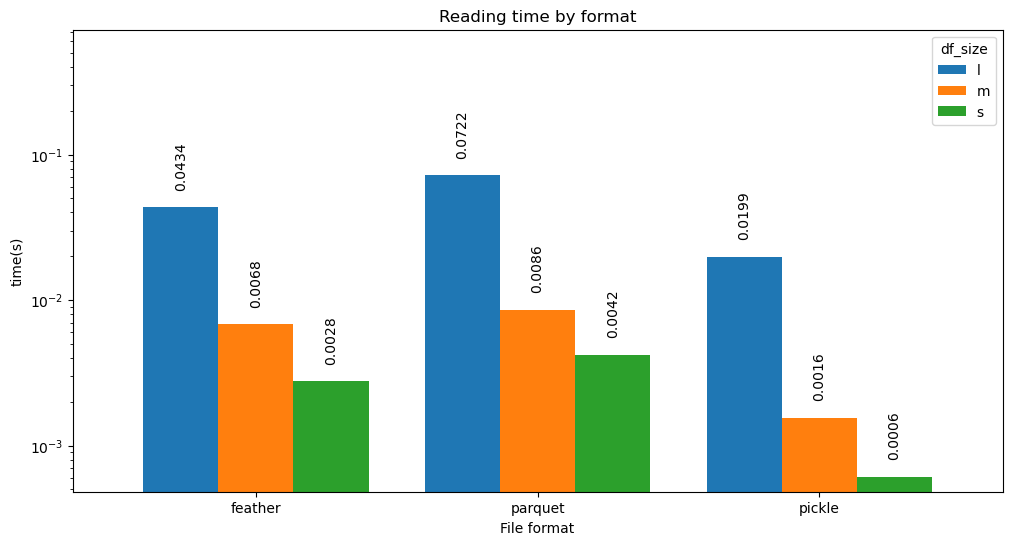

In [161]:
plot_data(binary['read'], 'Reading time by format', 'time(s)')

## write

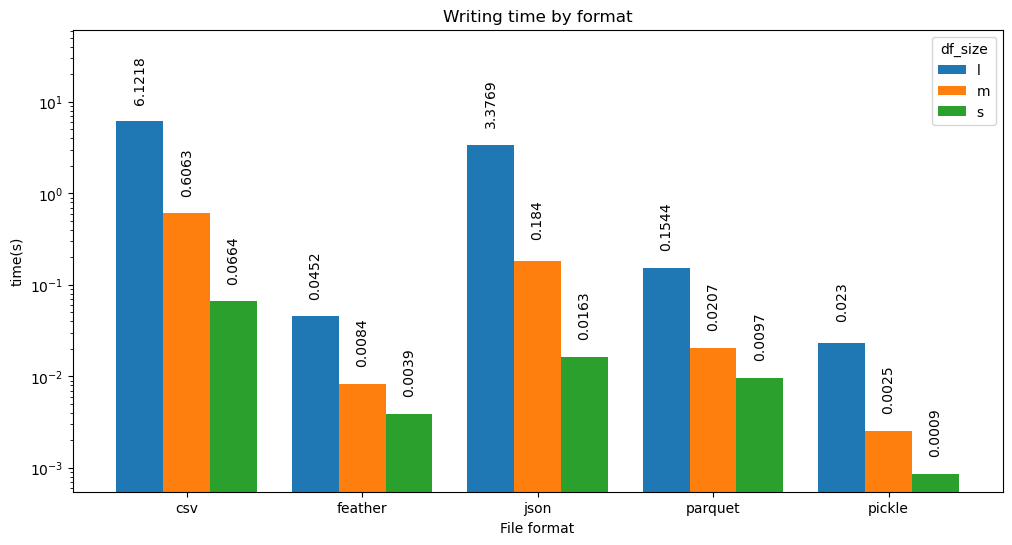

In [162]:
plot_data(grouped['write'], 'Writing time by format', 'time(s)')

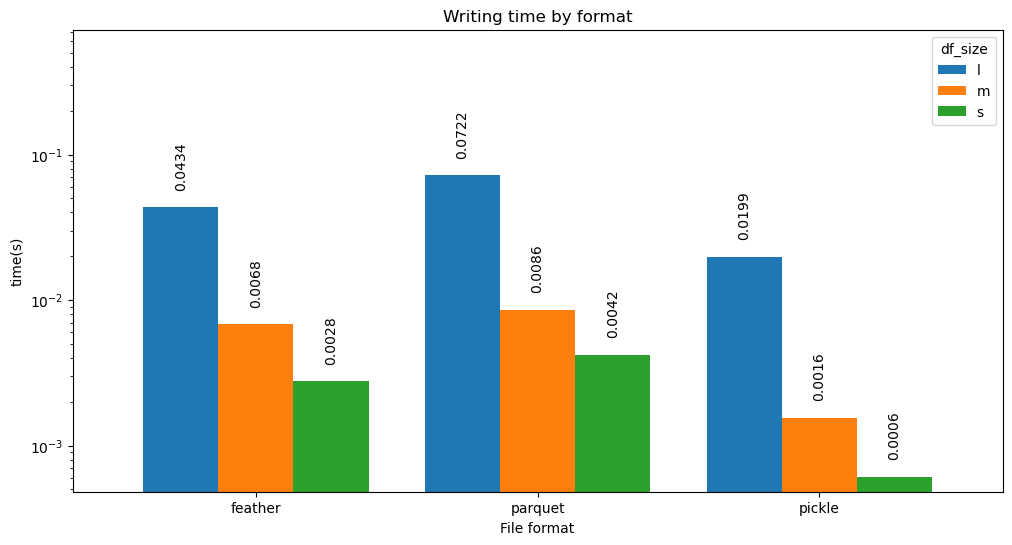

In [163]:
plot_data(binary['read'], 'Writing time by format', 'time(s)')

## size

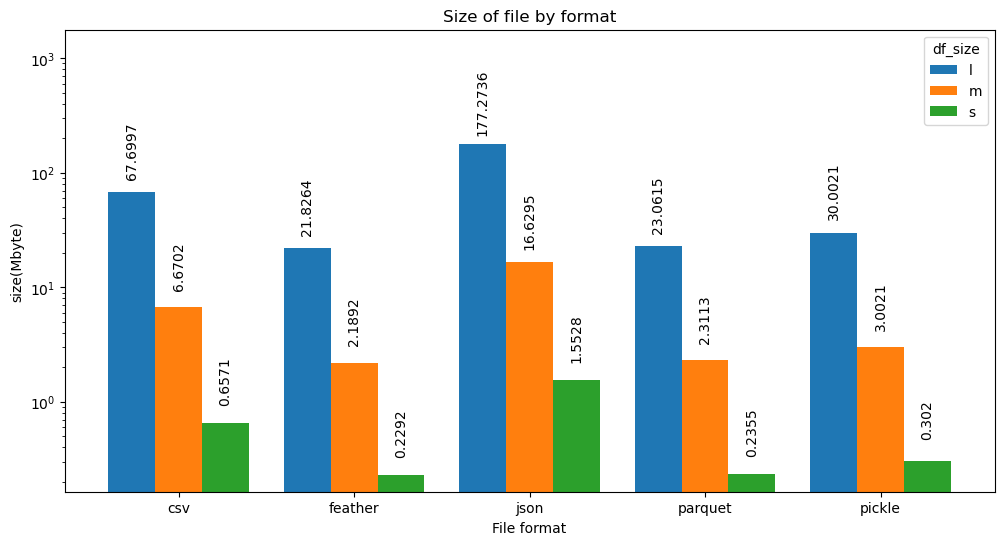

In [164]:
plot_data(grouped['size'], 'Size of file by format', 'size(Mbyte)')